In [1]:
##===================
# Installing required packages:
##===================

# - pandas for dataframes 
# - numpy for numerical computing
# - matplotlib for making graphs
# - seaborn for more complex graphs, complementary to matplotlib
# - scipy for statistical analysis
#
# For our ML models: 
# - sklearn.model_selection to split data to train and split
# - sklearn.linear_model to build a linear model
# - sklearn.metrics for evaluating the model
# - sklearn.preprocessing for making the polynomial model, and feature scaling
# - sklearn.svm for support vector regression
# - sklearn.ensemble import RandomForestRegressor
#
# For calculating time in python:
# - time


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#import statsmodels.api as sma
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor



import time

In [17]:
import matplotlib.image as mpimg

# Step 1: Collect Data

In [2]:
t01 = time.time() #For calculating how much time the whole code needs to run
min_calories_n = pd.read_csv(r"..\Data\minuteCaloriesNarrow_merged.csv")
min_steps_n = pd.read_csv(r"..\Data\minuteStepsNarrow_merged.csv")
sec_heartrate = pd.read_csv(r"..\Data\heartrate_seconds_merged.csv")
#weight = pd.read_csv(r"..\Data\weightLogInfo_merged.csv")

# Step 2: Inspect Data

In [3]:
#example is for sec_heartrate, but can be for any of the dataframes used 
dataset = sec_heartrate
print ("Data Preview: \n", dataset.head())# Top 10 lines of the df
#list(dataset)  # Columns of the df
print ("----")
print (" ")

#len(dataset)   # No of rows
print ("Dimensions of data (rows,columns): \n", dataset.shape)  # Dimensions of df
print ("----")
print (" ")

print ("Column datatypes: \n", dataset.dtypes) # Datatype of each column
print ("----")

print (" ")
print ("Class of object in each column *10th line")
for i in range (dataset.shape[1]):
    print (dataset.columns[i], 'is' ,type(dataset.iloc[:,i][10])) #returns the type of object in each column
                                               #type of the 14th line for each column
print ("----")
print (" ")
print ("Null Values per Column: \n", dataset.isnull().sum())
 # shows how many null values are in each colunm
print ("----")
print (" ")
print ('Unique Values Per Column:\n',dataset.nunique())
 # shows no of unique values for a specific column:
print ("----")
index = 0 #index of column for which unique values will be counted 
print ('No of entries for unique values for each',dataset.columns[index],':\n',(dataset.iloc[:,index]).value_counts())

Data Preview: 
            Id                  Time  Value
0  2022484408  4/12/2016 7:21:00 AM     97
1  2022484408  4/12/2016 7:21:05 AM    102
2  2022484408  4/12/2016 7:21:10 AM    105
3  2022484408  4/12/2016 7:21:20 AM    103
4  2022484408  4/12/2016 7:21:25 AM    101
----
 
Dimensions of data (rows,columns): 
 (2483658, 3)
----
 
Column datatypes: 
 Id        int64
Time     object
Value     int64
dtype: object
----
 
Class of object in each column *10th line
Id is <class 'numpy.int64'>
Time is <class 'str'>
Value is <class 'numpy.int64'>
----
 
Null Values per Column: 
 Id       0
Time     0
Value    0
dtype: int64
----
 
Unique Values Per Column:
 Id           14
Time     961274
Value       168
dtype: int64
----
No of entries for unique values for each Id :
 4020332650    285461
6962181067    266326
5553957443    255174
4388161847    249748
5577150313    248560
8877689391    228841
4558609924    192168
6117666160    158899
2022484408    154104
2347167796    152683
7007744171    

In [4]:
min_steps_n

,Id,ActivityMinute,Steps
0,1503960366,4/12/2016 12:00:00 AM,0
1,1503960366,4/12/2016 12:01:00 AM,0
2,1503960366,4/12/2016 12:02:00 AM,0
3,1503960366,4/12/2016 12:03:00 AM,0
4,1503960366,4/12/2016 12:04:00 AM,0
...,...,...,...
1325575,8877689391,5/12/2016 1:55:00 PM,0
1325576,8877689391,5/12/2016 1:56:00 PM,0
1325577,8877689391,5/12/2016 1:57:00 PM,0
1325578,8877689391,5/12/2016 1:58:00 PM,0


In [5]:
min_calories_n

,Id,ActivityMinute,Calories
0,1503960366,4/12/2016 12:00:00 AM,0.78650
1,1503960366,4/12/2016 12:01:00 AM,0.78650
2,1503960366,4/12/2016 12:02:00 AM,0.78650
3,1503960366,4/12/2016 12:03:00 AM,0.78650
4,1503960366,4/12/2016 12:04:00 AM,0.78650
...,...,...,...
1325575,8877689391,5/12/2016 1:55:00 PM,1.33353
1325576,8877689391,5/12/2016 1:56:00 PM,1.33353
1325577,8877689391,5/12/2016 1:57:00 PM,1.33353
1325578,8877689391,5/12/2016 1:58:00 PM,1.33353


# Step 3: Data transformations

We need to make a common dataframe that includes Id, Steps, Heartrate and Calories. For this reason we need to:  

####    1. Transform Heartrate data from values per second to values per minute.  
####    2. Extract two different features: Date and Time, from datetime values in the current 'Time' feature for each df.  
####    3. Create a final df of the relevand data: Perform Inner Joins of the dataframes according to the Id, Date and Time.  
    
    

### 1. Transforming Heartrate data from values per second to values per minute.

In [6]:
###
#Aggregating heartrate data (per 5 seconds) to per minute for comparison with other dataframes
###
t1 = time.time()
print((time.time()-t1)/60,0)

#renaming the Time column to DateTime
sec_heartrate.rename(columns = {'Time':'DateTime'}, inplace = True)
#
#test speed in making a new column with the same values and deleting the Time column
#


print((time.time()-t1)/60,1)

# Extracting the date from the DateTime
sec_heartrate['Date'] = pd.to_datetime(sec_heartrate.DateTime).dt.date

print ((time.time()-t1)/60,2)

# Extracting the time from the Datetime
sec_heartrate['Time'] = pd.to_datetime(sec_heartrate.DateTime).dt.time

print ((time.time()-t1)/60,3)

# Extracting the Hour and the Minute to help in aggregating by minute
sec_heartrate['Hour'] = pd.to_datetime(sec_heartrate.Time.astype(str)).dt.hour
sec_heartrate['Min'] = pd.to_datetime(sec_heartrate.DateTime.astype(str)).dt.minute

print ((time.time()-t1)/60,4)


#Aggregating heartrate data to per minute:

#Grouping to make a df of heartrates by minute, calculating the mean heartrate per minute
min_heartrate = sec_heartrate.groupby(['Id','Date','Hour','Min']).mean().reset_index()

print ((time.time()-t1)/60,5)

# changing the minute to the true value of the grouping (00:02:05 belongs to the 3rd minute)
min_heartrate['Min'] = min_heartrate['Min']-1 

print ((time.time()-t1)/60,6)

# correcting the -1 value to the 59thn minute of the hour
min_heartrate['Min'].mask(min_heartrate['Min']== -1,59,inplace=True) 

print ((time.time()-t1)/60,7)

# adding a time column to join with other dfs
min_heartrate['Time'] = (pd.to_datetime(min_heartrate['Hour'].astype(str) + ':' + min_heartrate['Min'].astype(str), format='%H:%M').dt.time)

print ((time.time()-t1)/60,8)

# removing Hour and Min features
min_heartrate.drop(['Hour', 'Min'], axis=1, inplace=True)

print ((time.time()-t1)/60,9)

#renaming the Value column to Heartbeat
min_heartrate.rename(columns = {'Value':'Heartbeat'}, inplace = True)

print('Took',(time.time()-t1)/60,'min') #calculating time needed for this cellfe to run

0.0 0
1.6621748606363933e-05 1
4.954748594760895 2
9.879432912667593 3
16.614968832333883 4
16.636139790217083 5
16.63620630502701 6
16.636274015903474 7
16.662932149569194 8
16.66338319381078 9
Took 16.66339759429296 min


In [7]:
sec_heartrate

,Id,DateTime,Value,Date,Time,Hour,Min
0,2022484408,4/12/2016 7:21:00 AM,97,2016-04-12,07:21:00,7,21
1,2022484408,4/12/2016 7:21:05 AM,102,2016-04-12,07:21:05,7,21
2,2022484408,4/12/2016 7:21:10 AM,105,2016-04-12,07:21:10,7,21
3,2022484408,4/12/2016 7:21:20 AM,103,2016-04-12,07:21:20,7,21
4,2022484408,4/12/2016 7:21:25 AM,101,2016-04-12,07:21:25,7,21
...,...,...,...,...,...,...,...
2483653,8877689391,5/12/2016 2:43:53 PM,57,2016-05-12,14:43:53,14,43
2483654,8877689391,5/12/2016 2:43:58 PM,56,2016-05-12,14:43:58,14,43
2483655,8877689391,5/12/2016 2:44:03 PM,55,2016-05-12,14:44:03,14,44
2483656,8877689391,5/12/2016 2:44:18 PM,55,2016-05-12,14:44:18,14,44


### 2. Extract two different features: Date and Time, from datetime values in the current 'Time' feature for each df.

In [8]:
t1 = time.time()
print((time.time()-t1)/60,0)

###
# Adding Date and Hour in min_calories_n df: 
###
min_calories_n['Date']=pd.to_datetime(min_calories_n['ActivityMinute']).dt.date
print((time.time()-t1)/60,1)
min_calories_n['Time']=pd.to_datetime(min_calories_n['ActivityMinute']).dt.time
print((time.time()-t1)/60,2)

###
# Adding Date and Hour in min_steps_n df: 
###
min_steps_n['Date']=pd.to_datetime(min_steps_n['ActivityMinute']).dt.date
print((time.time()-t1)/60,3)
min_steps_n['Time']=pd.to_datetime(min_steps_n['ActivityMinute']).dt.time
print((time.time()-t1)/60,4)

###
#Removing the ActivityMinute feature:
###
min_calories_n.drop(['ActivityMinute'], axis=1, inplace=True)
print((time.time()-t1)/60,5)

min_steps_n.drop(['ActivityMinute'], axis=1, inplace=True)
print('Took',(time.time()-t1)/60,'min')

0.0 0
2.5756453474362693 1
5.245677777131399 2
7.830583902200063 3
10.408550906181336 4
10.412109812100729 5
Took 10.4160142938296 min


### 3. Create a final dataframe of the relevand data: Perform inner joins of the dataframes according to the Id, Date and Time. 

In [9]:
###
#Merging data into one df
###
by_min = pd.merge(min_calories_n, min_steps_n, on=['Id','Date','Time'], how ="inner")
by_min = pd.merge(by_min, min_heartrate, on=['Id','Date','Time'], how ="inner")
by_min.reset_index(inplace = True, drop = True)
###
#Filtering out datapoints with steps <10, and Calories <2.5
###
# by_min = by_min.loc[(by_min.Steps > 10)&
#                (by_min.Calories >=2.5)]




In [10]:
#### Inspecting final df:
dataset = by_min
print ("Data Preview: \n", dataset.head())# Top 10 lines of the df
#list(dataset)  # Columns of the df
print ("----")
print (" ")

#len(dataset)   # No of rows
print ("Dimensions of data (rows,columns): \n", dataset.shape)  # Dimensions of df
print ("----")
print (" ")

print ("Column datatypes: \n", dataset.dtypes) # Datatype of each column
print ("----")

print (" ")
print ("Class of object in each column *10th line")
for i in range (dataset.shape[1]):
    print (dataset.columns[i], 'is' ,type(dataset.iloc[:,i][10])) #returns the type of object in each column
                                               #type of the 14th line for each column
print ("----")
print (" ")
print ("Null Values per Column: \n", dataset.isnull().sum())
 # shows how many null values are in each colunm
print ("----")
print (" ")
print ('Unique Values Per Column:\n',dataset.nunique())
 # shows no of unique values for a specific column:
print ("----")
index = 0 #index of column for which unique values will be counted 
print ('No of entries for unique values in column',dataset.columns[index],':\n',(dataset.iloc[:,index]).value_counts())

Data Preview: 
            Id  Calories        Date      Time  Steps   Heartbeat
0  2022484408   1.03770  2016-04-12  07:20:00      0  101.600000
1  2022484408   3.32064  2016-04-12  07:21:00     17   87.888889
2  2022484408   3.94326  2016-04-12  07:22:00      9   58.000000
3  2022484408   1.34901  2016-04-12  07:23:00      0   58.000000
4  2022484408   1.03770  2016-04-12  07:24:00      0   56.777778
----
 
Dimensions of data (rows,columns): 
 (333146, 6)
----
 
Column datatypes: 
 Id             int64
Calories     float64
Date          object
Time          object
Steps          int64
Heartbeat    float64
dtype: object
----
 
Class of object in each column *10th line
Id is <class 'numpy.int64'>
Calories is <class 'numpy.float64'>
Date is <class 'datetime.date'>
Time is <class 'datetime.time'>
Steps is <class 'numpy.int64'>
Heartbeat is <class 'numpy.float64'>
----
 
Null Values per Column: 
 Id           0
Calories     0
Date         0
Time         0
Steps        0
Heartbeat    0
dty

Some users have very few entries. Identifying for each user, the no of unique values for features, focusing on unique dates: 

In [11]:
# Unique values by user:
users_unique = by_min.groupby(['Id']).nunique().sort_values(['Date'], ascending=True)
users_unique

,Calories,Date,Time,Steps,Heartbeat
Id,,,,,
2026352035,26,4,366,68,277
4020332650,67,16,1440,113,6976
2347167796,79,18,1440,160,2320
6775888955,58,18,1440,130,1487
8792009665,57,18,1440,88,1869
6117666160,60,23,1440,125,1983
7007744171,60,24,1046,120,2150
5577150313,313,28,1440,138,3953
4388161847,106,30,1440,149,2591


The data exploration revealed that some users have fewer data. This is because data from the smartwatch was recorded for fewer days, as the analysis showed.

When looking to identifying general trends, this is an important finding. Any trends found for the user with only 3 days of data should be carefully evaluated compared to other users.

However, for building the models of the calories for each user, we will proceed with all the available data.

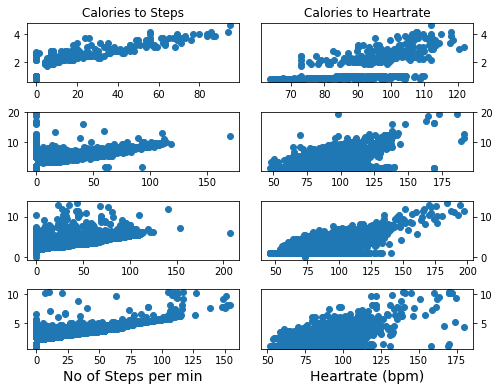

In [12]:
###
#Next we focus on some random users to view some of our data in scatter plots
###
fig, (axs) = plt.subplots(nrows=4, ncols=2, figsize=(8, 6))

id1 = by_min.Id.unique()[1]
id2 = by_min.Id.unique()[3]
id3 = by_min.Id.unique()[5]
id4 = by_min.Id.unique()[8]


axs[0,0].scatter(by_min.loc[by_min.Id ==id1].Steps,by_min.loc[by_min.Id == id1].Calories)
axs[0,1].scatter(by_min.loc[by_min.Id ==id1].Heartbeat,by_min.loc[by_min.Id == id1].Calories)

axs[1,0].scatter(by_min.loc[by_min.Id ==id2].Steps,by_min.loc[by_min.Id == id2].Calories)
axs[1,1].scatter(by_min.loc[by_min.Id ==id2].Heartbeat,by_min.loc[by_min.Id == id2].Calories)

axs[2,0].scatter(by_min.loc[by_min.Id ==id3].Steps,by_min.loc[by_min.Id == id3].Calories)
axs[2,1].scatter(by_min.loc[by_min.Id ==id3].Heartbeat,by_min.loc[by_min.Id == id3].Calories)

axs[3,0].scatter(by_min.loc[by_min.Id ==id4].Steps,by_min.loc[by_min.Id == id4].Calories)
axs[3,1].scatter(by_min.loc[by_min.Id ==id4].Heartbeat,by_min.loc[by_min.Id == id4].Calories)

axs[0,0].yaxis.tick_left()
axs[1,0].yaxis.tick_left()
axs[2,0].yaxis.tick_left()
axs[3,0].yaxis.tick_left()

axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.tick_right()
axs[2,1].yaxis.tick_right()
axs[3,1].yaxis.tick_right()

axs[3,0].set_xlabel('No of Steps per min',fontsize='14')
axs[3,1].set_xlabel('Heartrate (bpm)',fontsize='14')

axs[0,0].set_title('Calories to Steps')
axs[0,1].set_title('Calories to Heartrate')

plt.subplots_adjust(hspace=0.5,wspace=0.1)

plt.show()

### Focusing on irregularities:
 - Evaluating the Calories to Steps scatter plots, the data for the lowest values of steps, have a lot of calories burned. 
 - Evaluating the Calories to Heartrate scatter plots, the data for the lowest values of calories burned have a high heartrate (Almost a line for 0 calories is evident for the analysed users). 
 
This could be some error of the recrding device. For the purpose modeling calories with steps and heartrate, we will ignore the lowest values of steps, and the lowest values of caloreis burned. Our initial model, will work well for:
- more than 10 steps per min,
- more than 2.5 calories burned per min.

In [13]:
###
# Filtering values
###

#Choosing values that have more than 10 Steps per min, and more than 2.5 Calories per min


all_users = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)]

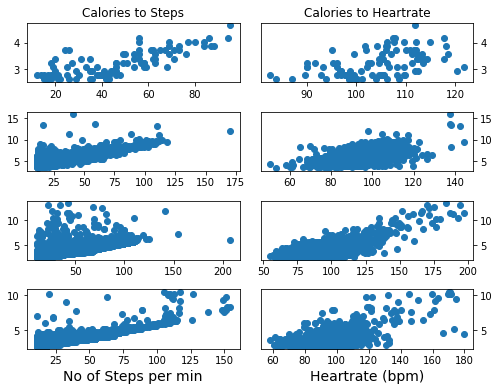

In [14]:
###
#Veryfying that the cleaning was effective:
###
fig, (axs) = plt.subplots(nrows=4, ncols=2, figsize=(8, 6))
df = all_users
id1 = df.Id.unique()[1]
id2 = df.Id.unique()[3]
id3 = df.Id.unique()[5]
id4 = df.Id.unique()[8]


axs[0,0].scatter(df.loc[df.Id ==id1].Steps,df.loc[df.Id == id1].Calories)
axs[0,1].scatter(df.loc[df.Id ==id1].Heartbeat,df.loc[df.Id == id1].Calories)

axs[1,0].scatter(df.loc[df.Id ==id2].Steps,df.loc[df.Id == id2].Calories)
axs[1,1].scatter(df.loc[df.Id ==id2].Heartbeat,df.loc[df.Id == id2].Calories)

axs[2,0].scatter(df.loc[df.Id ==id3].Steps,df.loc[df.Id == id3].Calories)
axs[2,1].scatter(df.loc[df.Id ==id3].Heartbeat,df.loc[df.Id == id3].Calories)

axs[3,0].scatter(df.loc[df.Id ==id4].Steps,df.loc[df.Id == id4].Calories)
axs[3,1].scatter(df.loc[df.Id ==id4].Heartbeat,df.loc[df.Id == id4].Calories)

axs[0,0].yaxis.tick_left()
axs[1,0].yaxis.tick_left()
axs[2,0].yaxis.tick_left()
axs[3,0].yaxis.tick_left()

axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.tick_right()
axs[2,1].yaxis.tick_right()
axs[3,1].yaxis.tick_right()

axs[3,0].set_xlabel('No of Steps per min',fontsize='14')
axs[3,1].set_xlabel('Heartrate (bpm)',fontsize='14')

axs[0,0].set_title('Calories to Steps')
axs[0,1].set_title('Calories to Heartrate')

plt.subplots_adjust(hspace=0.5,wspace=0.1)

plt.show()

Our Scatter plots also suggest linear correlations between Calories and Steps, and Calories and Heartrate. This Correlation was expected considering the nature of the data. Next we focus further on possible correlations.

# Step 4: Checking for dependencies
## (i) For all the data points
#### Matrix of scatter plots: 

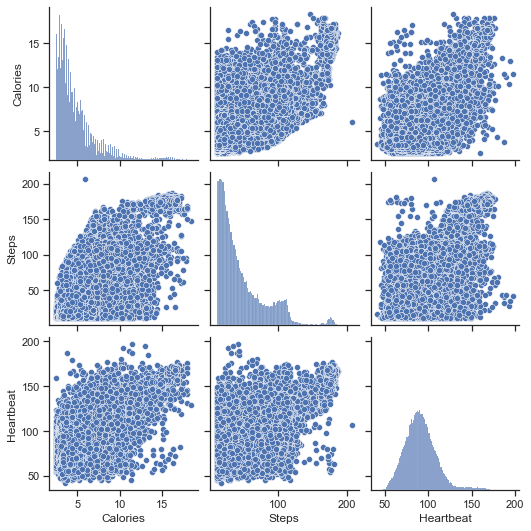

In [15]:
sns.set_theme(style="ticks")
sns.pairplot(all_users.iloc[:, [1,4,5]])

#### Conclusion:
    When looking all the datapoints, there is no obvious dependencies between any of the features. 

## (ii) Personalized analysis for each user

### Checking for dependencies, for two random users

#### Matrix of scatter plots:

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


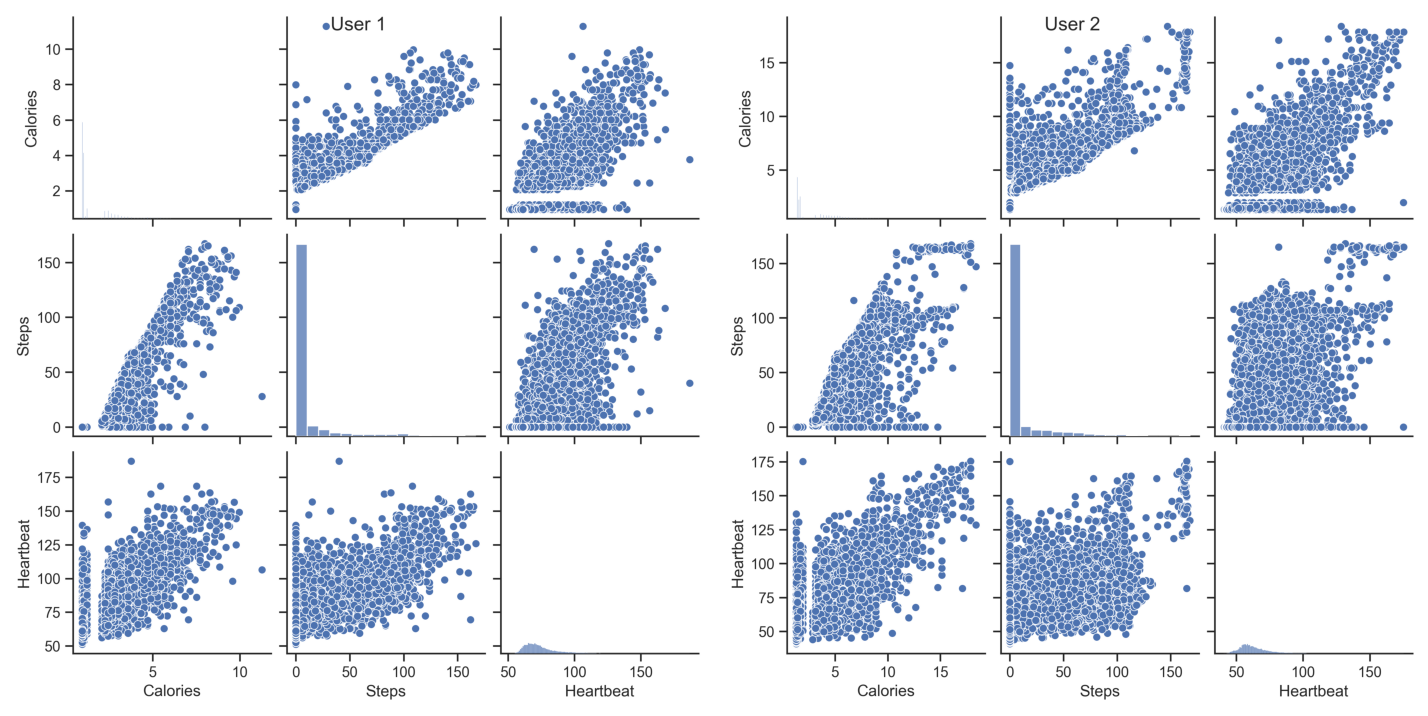

In [18]:
def pairplot(df):

    sns.set(style="ticks")
    return sns.pairplot(df) # !!! I've placed a return

df1 = by_min.loc[by_min.Id == by_min.Id.unique()[2]]
df2 = by_min.loc[by_min.Id == by_min.Id.unique()[4]]

df1.drop(['Id'], axis=1, inplace=True)
df2.drop(['Id'], axis=1, inplace=True)



g0 = pairplot(df1)
g0.fig.suptitle("User 1")
g1 = pairplot(df2)
g1.fig.suptitle("User 2")



############### 1. SAVE PLOTS IN MEMORY TEMPORALLY
g0.savefig('g0.png', dpi=300)
plt.close(g0.fig)

g1.savefig('g1.png', dpi=300)
plt.close(g1.fig)


############### 2. CREATE SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(1, 2, figsize=(20, 20))

axarr[0].imshow(mpimg.imread('g0.png'))
axarr[1].imshow(mpimg.imread('g1.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig("ScatterPlot")
plt.show()

### Our data reveals different correlation-relations for different users

|Feature-pairs       | User 1           | User 2          |
|--------------------|------------------|--------|
| Calories-Heartbeat | Correlation      | Correlation    |
| Calories-Steps     | Correlation      | Correlation   |
| Steps-Heartbeat    | Correlation  | No Correlation |


#### Pairwise correlation of all columns
        - Calculating the Pearson and Spearman correlation coefficients between the different features

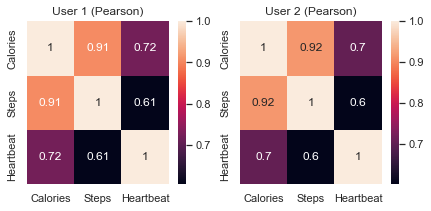

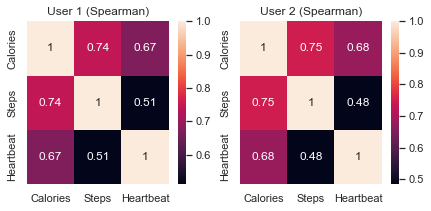

In [19]:
###
#Side by side heatmap of Pearson coefficients for the two users
###
sns.set(rc = {'figure.figsize':(7,3)})
fig, ax =plt.subplots(1,2)

sns.heatmap(df1.corr('pearson'),annot=True, ax=ax[0]) 
sns.heatmap(df2.corr('pearson'),annot=True, ax=ax[1])
ax[0].set_title("User 1 (Pearson)")
ax[1].set_title("User 2 (Pearson)")

plt.show()

###
#Side by side heatmap of Spearman coefficients for the two users
###
sns.set(rc = {'figure.figsize':(7,3)})
fig, ax =plt.subplots(1,2)

sns.heatmap(df1.corr('spearman'),annot=True, ax=ax[0]) 
sns.heatmap(df2.corr('spearman'),annot=True, ax=ax[1])
ax[0].set_title("User 1 (Spearman)")
ax[1].set_title("User 2 (Spearman)")

plt.show()

#### According to the correlation coefficients, there is a strong correlation between Calories and Steps, for both users, and  a moderate correlation between Calories and Heartbeat


In [20]:
###
#Estimating the importance of linear correlations with evaluation of the p-value (for borth users)
###


#list of features we are interested
feat = ['Calories','Steps','Heartbeat']

# Creating an empty df to fill with p-values between features
p_list = pd.DataFrame()
p_user1 = []
p_user2 = []
p_list["Feat1"] = [feat[0],feat[1],feat[2]]
p_list["Feat2"] = [feat[1],feat[2],feat[0]]


#Choosing the dfs for two users
df1 = by_min.loc[by_min.Id == by_min.Id.unique()[2]]
df2 = by_min.loc[by_min.Id == by_min.Id.unique()[4]]
df1.drop(['Id'], axis=1, inplace=True)
df2.drop(['Id'], axis=1, inplace=True)


#list of dfs for each user
p_user1.append(stats.linregress(df1['Calories'],df1['Steps'])[3])
p_user1.append(stats.linregress(df1['Steps'],df1['Heartbeat'])[3])
p_user1.append(stats.linregress(df1['Heartbeat'],df1['Calories'])[3])


p_user2.append(stats.linregress(df2['Calories'],df2['Steps'])[3])
p_user2.append(stats.linregress(df2['Steps'],df2['Heartbeat'])[3])
p_user2.append(stats.linregress(df2['Heartbeat'],df2['Calories'])[3])


p_list['User1_p-value'] = p_user1
p_list['User2_p-value'] = p_user2

print ("p-value for users 1 and 2:")
display(p_list)

p-value for users 1 and 2:


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Feat1,Feat2,User1_p-value,User2_p-value
0,Calories,Steps,0.0,0.0
1,Steps,Heartbeat,0.0,0.0
2,Heartbeat,Calories,0.0,0.0


The small values of p-values support the linear correlation hypothesis.

### From Pearson coefficient, Spearman coefficient and p-value, we conclude that:
    - Calories depend from Steps and,
    - Calories depend from Heartbeat.   

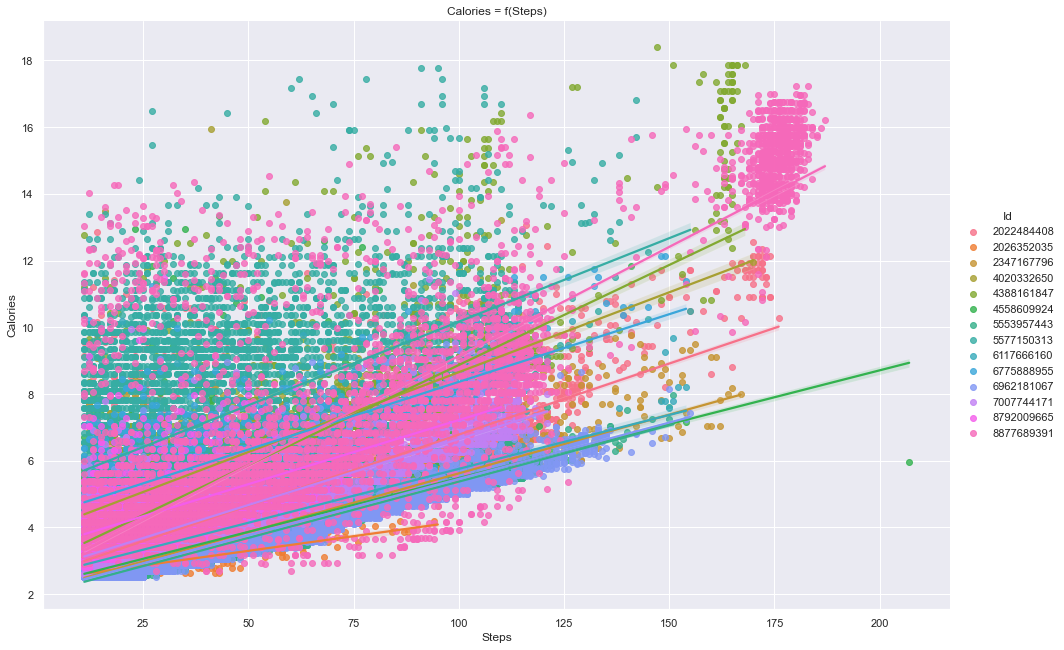

In [21]:
###
#Linear regressions of Callories with relation to Steps for each user:
###

sns.set_theme()
###
#filtering users with steps > 10 per min and calories >= 2.5 
###

df = all_users

g = sns.lmplot(
    data=df,
    x="Steps", y="Calories", hue="Id",
    height=9, aspect=1.5
    )
g.set_axis_labels("Steps", "Calories")

ax = plt.gca()
ax.set_title("Calories = f(Steps)")
plt.show()

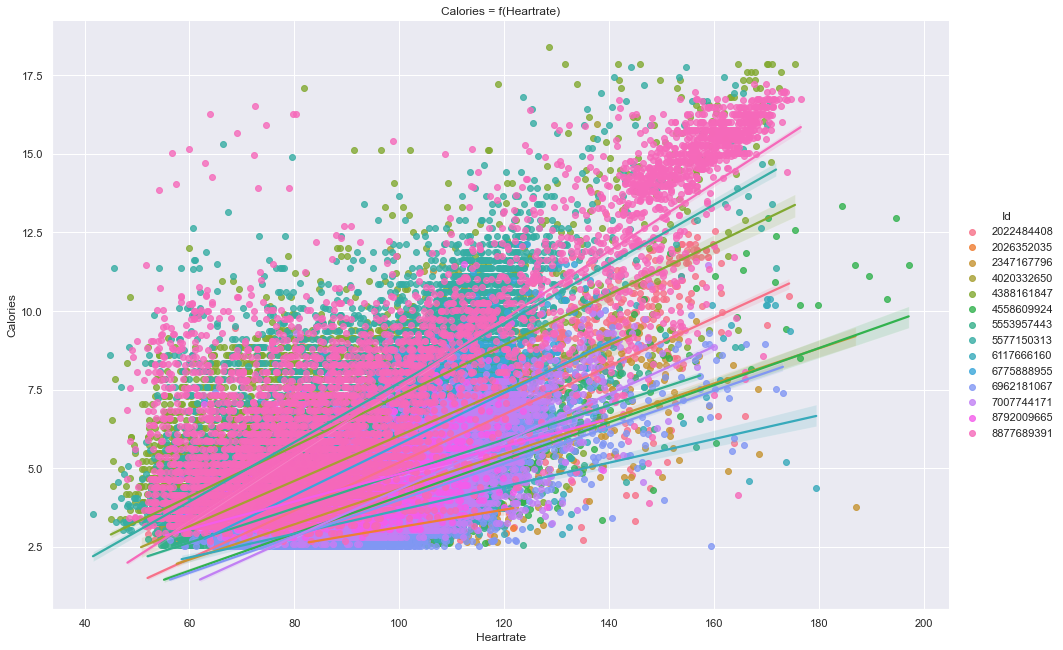

In [22]:
###
#General view of linear regression of Callories with relation to Heartrate
###

sns.set_theme()

df = all_users
# df = by_min.loc[(by_min.Steps > 10)&
#                (by_min.Calories >=2.5)]

g = sns.lmplot(
    data=df,
    x="Heartbeat", y="Calories", hue="Id",
    height=9, aspect=1.5
)

g.set_axis_labels("Heartrate", "Calories")

ax = plt.gca()
ax.set_title("Calories = f(Heartrate)")
plt.show()

### Conclusion:

    - From the simple linear fits for every user, we see that linear models do not fit the data well.
            For heartrates over 140, and for steps over 150 we see that the linear model is off. In the next steps, we will      calculate sinmple linear models, and see how the accuracy of our models changes as we add both features in to our models. 

## Next we compare the following models:
    - Simple Linear Regression (Calories Vs Heartrate)
    - Simple Linear Regression (Calories Vs Steps)
    - Multi Linear Regression  (Calories Vs both Heartrate and Steps)
    - Polynomial Regression, 2nd degree, (Caloreis Vs Steps)
    - Polynomial Regression, 2nd degree, (Caloreis Vs Heartrate)
    - (Multi-)Polynomial Regression, 2nd degree, (Caloreis Vs Steps and Heartrate)
    - (Multi-)Polynomial Regression, 3rd degree, (Caloreis Vs Steps and Heartrate)
    - Support Vector Regression, (Calories Vs Steps)
    - (Multivariant) Support Vector Regression, (Calories Vs Steps and Heartrate)
    - Random Forest Regression, (Calories Vs Steps and Heartrate)

We compare models base on the R square value 

## A preview of each model for a random user:

In [23]:
###
#Choosing a random Id:
###
user_id = by_min.Id[23456]

#For model evaluation:
###
#Lists to be filled for each model, for final comparison of R square values
###
Model_Descr = []
Rsq = []

# Simple Linear Regression

Rsquare = 0.4347


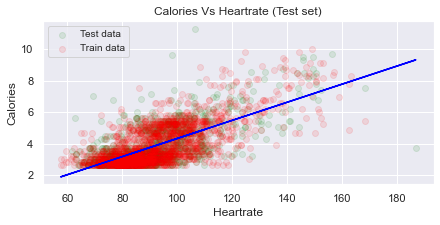

In [24]:
#######
#Simple linear regression, Calories Vs Heartrate
#######


def SLR_CalVsHeartrate(user_id):
    
    ###
    #Defining dataset
    ###
    df = all_users.loc[(all_users.Id == user_id)]

    X = df.iloc[:, -1].values.reshape(-1, 1) #Choosing heartrate
    y = df.iloc[:, 1].values

    ###
    #Splitting the dataset into the Training set and Test set
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

    ###
    #Training the Simple Linear Regression model on the training set
    ###
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    ###
    #Getting the final linear regression equation with the values of the coefficients
    ###
    # print ('y = b0 + b1*x'
    # print('b1:',lin_reg.coef_[0]) #b1
    # print('b0',lin_reg.intercept_) #b0

    ###
    #Predicting results
    ###
    y_pred = regressor.predict(X_test)
    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)
    return (rsq, X_test,y_test,X_train,y_train,X, regressor)

rsq, X_test,y_test,X_train,y_train,X, regressor = SLR_CalVsHeartrate(user_id)

###
#Model Evaluation
###
Model_Descr.append('Linear_CalVsHeartrate')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)

###
#Visualisigin the Linear regression result of the full dataset fit ():
###

plt.scatter(X_test,y_test, color = 'green', alpha=0.1, label = 'Test data')
plt.scatter(X_train,y_train, color = 'red', alpha=0.1,label = 'Train data')
plt.plot(X,regressor.predict(X), color = 'blue')
plt.title('Calories Vs Heartrate (Test set)')
plt.xlabel('Heartrate')
plt.ylabel('Calories')
plt.legend(prop={'size': 10},loc=2)
plt.show()

Rsquare = 0.8008


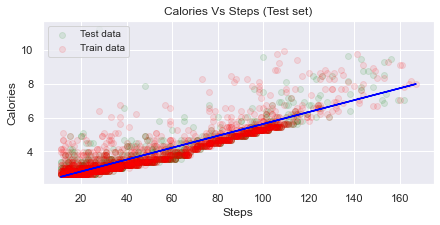

In [25]:
#######
#Simple linear regression, Calories Vs Steps
#######


def SLR_CalVsSteps(user_id):
    
    ###
    #Defining dataset
    ###
    df = all_users.loc[(all_users.Id == user_id)]

    X = df.iloc[:, -2].values.reshape(-1, 1) #Choosing steps
    y = df.iloc[:, 1].values

    ###
    #Splitting the dataset into the Training set and Test set
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

    ###
    #Training the Simple Linear Regression model on the training set
    ###
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    ###
    #Getting the final linear regression equation with the values of the coefficients
    ###
    # print ('y = b0 + b1*x'
    # print('b1:',lin_reg.coef_[0]) #b1
    # print('b0',lin_reg.intercept_) #b0

    ###
    #Predicting results
    ###
    y_pred = regressor.predict(X_test)
    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)
    return (rsq, X_test,y_test,X_train,y_train,X, regressor)

rsq, X_test,y_test,X_train,y_train,X, regressor = SLR_CalVsSteps(user_id)

###
#Model Evaluation
###
Model_Descr.append('Linear_CalVsSteps')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)

###
#Visualisigin the Linear regression result of the full dataset fit ():
###

plt.scatter(X_test,y_test, color = 'green', alpha=0.1, label = 'Test data')
plt.scatter(X_train,y_train, color = 'red', alpha=0.1,label = 'Train data')
plt.plot(X,regressor.predict(X), color = 'blue')
plt.title('Calories Vs Steps (Test set)')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.legend(prop={'size': 10},loc=2)
plt.show()

In [26]:
#R_square values:
Rsquare_Values = [SLR_CalVsHeartrate(user_id)[0],SLR_CalVsSteps(user_id)[0]]

#Model descr:
Models = ['Linear_CalVsHeartrate','Linear_CalVsSteps']

# Multilinear regression

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Rsquare = 0.8425


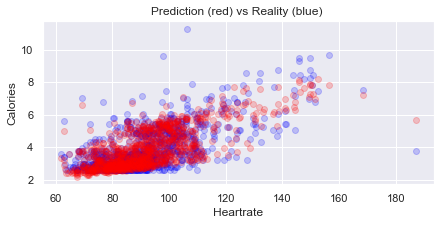

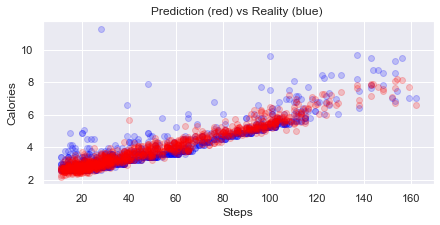

Step Slope: 0.02899991499749665
HR Slope: 0.022163857749773395
Intercept: 0.37419518332898694
Rsq: 0.8425357000346463


In [28]:
#######
#Multi linear regression, Calories Vs (Steps,Heartrate)
#######


def multi_linear(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:, 1:3].values
    y = df.iloc[:, 0].values

    ###
    #Splitting training-test set
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

    ###
    #Training the Multiple Linear Regression model on the Training set
    ###
    regressor = LinearRegression()
    regressor.fit(X_train,y_train)

    ###
    #Making the Calorie prediction:
    ###
    y_pred = regressor.predict(X_test)

    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)
    
    return (rsq, X_test,y_test,X_train,y_train,y_pred,regressor)

rsq, X_test,y_test,X_train,y_train,y_pred,regressor = multi_linear(user_id)
    
Model_Descr.append('Multi_Linear')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)


###
#Visualizing prediction Vs Reality on Calories = f(Heartrate) :
###
plt.scatter(X_test[:,1], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
plt.scatter(X_test[:,1], y_pred, color = 'red', alpha = 0.2)
plt.title('Prediction (red) vs Reality (blue) ')
plt.xlabel('Heartrate')
plt.ylabel('Calories')
plt.show()

###
#Visualizing prediction Vs Reality on Calories = f(Steps) :
###
plt.scatter(X_test[:,0], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
plt.scatter(X_test[:,0], y_pred, color = 'red', alpha = 0.2)
plt.title('Prediction (red) vs Reality (blue) ')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show()

print('Step Slope:',regressor.coef_[0])  #calling an attribute of the object
print('HR Slope:',regressor.coef_[1])  #calling an attribute of the object
print('Intercept:',regressor.intercept_)
print ('Rsq:',r2_score(y_test,y_pred))

# Polynomial Regression

Rsquare = 0.8214


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function matplotlib.pyplot.show(close=None, block=None)>

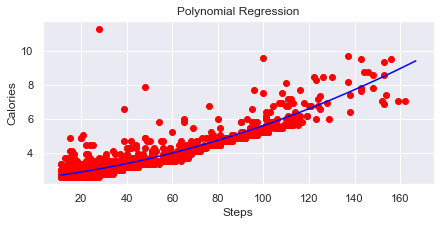

In [34]:
#######
#Polynomial Regression (Calories = f(Steps)), second degree
#######

def polyn_CalVsSteps(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:,1:-1].values
    y = df.iloc[:, 0].values

    ###
    #Splitting training-test set
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

    ###
    #Building and training our polynomial model (2nd degree)
    ###
    poly_reg = PolynomialFeatures(degree = 2)
             #matrix of features
    X_poly_train = poly_reg.fit_transform(X_train)
    X_poly_test = poly_reg.fit_transform(X_test)
            #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
            #trasforms the object to our polynomial

    lin_reg_2 = LinearRegression() #building a new linear regression object that 
                                   #will be trained in the new matrix of features
    lin_reg_2.fit(X_poly_train,y_train)

    ###
    #Making the Calorie prediction:
    ###
    y_pred = lin_reg_2.predict(X_poly_test)

    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)

    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,lin_reg_2,poly_reg)

    
rsq, X_test,y_test,X_train,y_train,y_pred,X,lin_reg_2,poly_reg = polyn_CalVsSteps(user_id)

Model_Descr.append('Poly_CalVsSteps_2nd')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)

###
#Visualising the polynomial regression results
###

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('Polynomial Regression')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show

# print('Polynomial Coefficients:')
# print('y = b0 + b1*X + b2*X^2')
# print('b0:',lin_reg_2.intercept_)
# print ('b1:',lin_reg_2.coef_[1])
# print ('b2:',lin_reg_2.coef_[2])
# print ('Rsq:',r2_score(y,lin_reg_2.predict(X_poly)))

Rsquare = 0.4350


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function matplotlib.pyplot.show(close=None, block=None)>

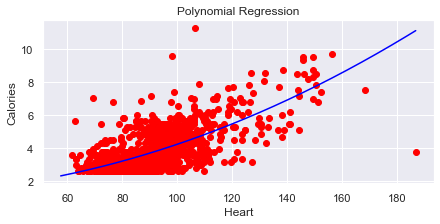

In [35]:
#######
#Polynomial Regression (Calories = f(Heartrate)), second degree
#######

def polyn_CalVsHeart(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    #X = df.iloc[:,1:-1].values
    X = df.iloc[:,2:].values
    y = df.iloc[:, 0].values

    ###
    #Splitting training-test set
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

    ###
    #Building and training our polynomial model (2nd degree)
    ###
    poly_reg = PolynomialFeatures(degree = 2)
             #matrix of features
    X_poly_train = poly_reg.fit_transform(X_train)
    X_poly_test = poly_reg.fit_transform(X_test)
            #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
            #trasforms the object to our polynomial

    lin_reg_2 = LinearRegression() #building a new linear regression object tha that 
                                   #will be trained in the new matrix of features
    lin_reg_2.fit(X_poly_train,y_train)

    ###
    #Making the Calorie prediction:
    ###
    y_pred = lin_reg_2.predict(X_poly_test)

    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)

    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,lin_reg_2)

    
rsq, X_test,y_test,X_train,y_train,y_pred,X,lin_reg_2 = polyn_CalVsHeart(user_id)

Model_Descr.append('Poly_CalVsHeart_2nd')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)

###
#Visualising the polynomial regression results
###

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('Polynomial Regression')
plt.xlabel('Heart')
plt.ylabel('Calories')
plt.show

# print('Polynomial Coefficients:')
# print('y = b0 + b1*X + b2*X^2')
# print('b0:',lin_reg_2.intercept_)
# print ('b1:',lin_reg_2.coef_[1])
# print ('b2:',lin_reg_2.coef_[2])
# print ('Rsq:',r2_score(y,lin_reg_2.predict(X_poly)))

In [36]:
#R_square values:
Rsquare_Values = [SLR_CalVsHeartrate(user_id)[0],SLR_CalVsSteps(user_id)[0], multi_linear(user_id)[0],
                  polyn_CalVsSteps(user_id)[0],polyn_CalVsHeart(user_id)[0]
                 ]

#Model descr:
Models = ['Linear_CalVsHeartrate','Linear_CalVsSteps','Multi_Linear',
          'Poly_CalVsSteps_2nd','Poly_CalVsHeart_2nd',
         ]

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Multivariate Polynomial Regression

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Rsquare = 0.8500


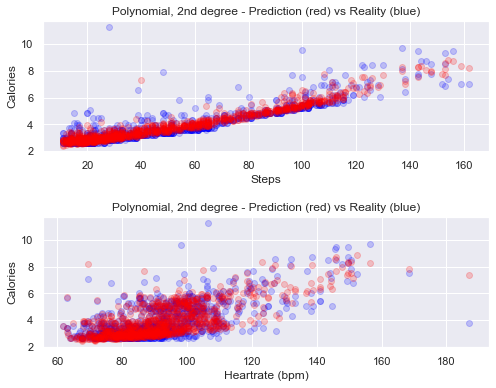

In [37]:
###
#Polynomial Regression - 2nd degree (Calories = f(Heartrate, Steps))
###

def multi_polyn_2nd(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:,1:].values #choosing heartrate and steps as X
    y = df.iloc[:, 0].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
            # Note: we do first the train_test_split and then the feature transformation, in order to 
            # have the X_train and X_test values for graphing the results later

    poly_reg = PolynomialFeatures(degree=2)
            # matrix of features 

    X_train_poly =  poly_reg.fit_transform(X_train)   
    X_test_poly =  poly_reg.fit_transform(X_test)   
            #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
            #trasforms the object to our polynomial

    ###
    #Building and training our polynomial model (2nd degree)
    ###
    regression = LinearRegression()
    model = regression.fit(X_train_poly, y_train)

    ###
    #Making the Calorie prediction:
    ###
    y_pred = model.predict(X_test_poly)


    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)
    
    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,model)
    
rsq, X_test,y_test,X_train,y_train,y_pred,X,model = multi_polyn_2nd(user_id)

Model_Descr.append('Poly_Multivariant_2nd')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)



###
#Visualizing results (projection of 3 dimension (calories, heartrate, steps) to two dimension)
###

fig, (axs) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axs[0].scatter(X_test[:,0], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
axs[0].scatter(X_test[:,0], y_pred, color = 'red', alpha = 0.2)
axs[0].set_title('Polynomial, 2nd degree - Prediction (red) vs Reality (blue)')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Calories')

axs[1].scatter(X_test[:,1], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
axs[1].scatter(X_test[:,1], y_pred, color = 'red', alpha = 0.2)
axs[1].set_title('Polynomial, 2nd degree - Prediction (red) vs Reality (blue)')
axs[1].set_xlabel('Heartrate (bpm)')
axs[1].set_ylabel('Calories')

plt.subplots_adjust(hspace=0.5,wspace=0.1)

plt.show()

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Rsquare = 0.8571


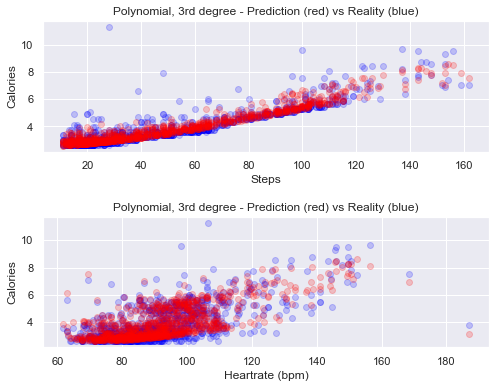

In [38]:
###
#Polynomial Regression - 3rd degree (Calories = f(Heartrate, Steps))
###

def multi_polyn_3rd(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:,1:].values #choosing heartrate and steps as X
    y = df.iloc[:, 0].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
            # Note: we do first the train_test_split and then the feature transformation, in order to 
            # have the X_train and X_test values for graphing the results later

    poly_reg = PolynomialFeatures(degree=3)
            # matrix of features 

    X_train_poly =  poly_reg.fit_transform(X_train)   
    X_test_poly =  poly_reg.fit_transform(X_test)   
            #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
            #trasforms the object to our polynomial

    ###
    #Building and training our polynomial model (2nd degree)
    ###
    regression = LinearRegression()
    model = regression.fit(X_train_poly, y_train)

    ###
    #Making the Calorie prediction:
    ###
    y_pred = model.predict(X_test_poly)


    ###
    #Evaluating the model:
    ###
    rsq = r2_score(y_test, y_pred)
    
    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,model)
    
rsq, X_test,y_test,X_train,y_train,y_pred,X,model = multi_polyn_3rd(user_id)

Model_Descr.append('Poly_Multivariant_3rd')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)



###
#Visualizing results (projection of 3 dimension (calories, heartrate, steps) to two dimension)
###

fig, (axs) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axs[0].scatter(X_test[:,0], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
axs[0].scatter(X_test[:,0], y_pred, color = 'red', alpha = 0.2)
axs[0].set_title('Polynomial, 3rd degree - Prediction (red) vs Reality (blue)')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Calories')

axs[1].scatter(X_test[:,1], y_test, color = 'blue', alpha = 0.2) #X_test[:,3] is one of the variables that I chose to show the Visualization
axs[1].scatter(X_test[:,1], y_pred, color = 'red', alpha = 0.2)
axs[1].set_title('Polynomial, 3rd degree - Prediction (red) vs Reality (blue)')
axs[1].set_xlabel('Heartrate (bpm)')
axs[1].set_ylabel('Calories')

plt.subplots_adjust(hspace=0.5,wspace=0.1)

plt.show()

# Support Vector Regression (SVR)

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Rsquare = 0.8531


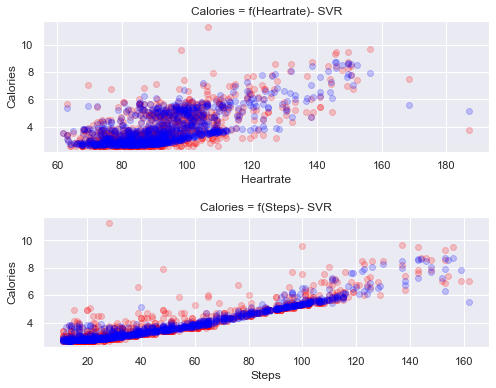

In [39]:
###
#SVR regression for Calories = f(Steps, Heartrate)
###

def multi_SVR(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:,1:].values #choosing heartrate and steps as X
    y = df.iloc[:, 0].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
            # Note: we do first the train_test_split and then the feature transformation, in order to 
            # have the X_train and X_test values for graphing the results later


    ###
    #Feature scaling
    ###

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_s = sc_X.fit_transform(X_train)
    y_train_s = sc_y.fit_transform(y_train.reshape(-1, 1))
    X_test_s = sc_X.fit_transform(X_test)
    y_test_s = sc_y.fit_transform(y_test.reshape(-1, 1))


    ###
    #Training the SVR model on the train dataset
    ###
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train_s, y_train_s)

    ###
    #Predicting values for all X_test
    ###
    y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))

    ###
    #Evaluating the model
    ###
    rsq = r2_score(y_test, y_pred)

    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor)

rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor = multi_SVR(user_id)

Model_Descr.append('multi_SVR')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)


###
#Visualising the SVR results
###
fig, (axs) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axs[0].scatter(X_test[:,1:], y_test, color = 'red',alpha = 0.2)
axs[0].scatter(X_test[:,1:], y_pred, color = 'blue',alpha = 0.2)

axs[0].set_title('Calories = f(Heartrate)- SVR')
axs[0].set_xlabel('Heartrate')
axs[0].set_ylabel('Calories')

axs[1].scatter(X_test[:,0:1], y_test, color = 'red',alpha = 0.2)
axs[1].scatter(X_test[:,0:1], y_pred, color = 'blue',alpha = 0.2)

axs[1].set_title('Calories = f(Steps)- SVR')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Calories')

plt.subplots_adjust(hspace=0.5,wspace=0.1)
plt.show()


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Rsquare = 0.8143


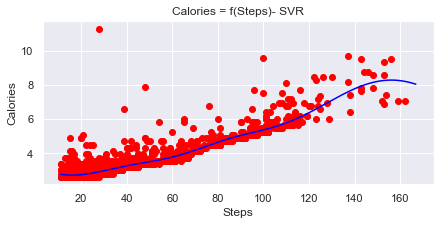

In [42]:
###
#SVR regression for Calories = f(Steps)
###



def SVR_steps(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = df.iloc[:,1:-1].values # Choosing Steps
    #X = dataset.iloc[:,2:].values # Choosing Heartbeat
    y = df.iloc[:, 0].values.reshape(-1, 1)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
            # Note: we do first the train_test_split and then the feature transformation, in order to 
            # have the X_train and X_test values for graphing the results later

    ###
    #Feature scaling
    ###
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_s = sc_X.fit_transform(X_train)
    y_train_s = sc_y.fit_transform(y_train.reshape(-1, 1))
    X_test_s = sc_X.fit_transform(X_test)
    y_test_s = sc_y.fit_transform(y_test.reshape(-1, 1))

    ###
    #Training the SVR model on the training dataset
    ###
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train_s, y_train_s)       

    ###
    #Predicting values for X_test values
    ###
    y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))



    ###
    #Evaluating the model
    ###
    rsq = r2_score(y_test, y_pred)
    
    
    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor,sc_y,sc_X)
    
rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor,sc_y,sc_X = SVR_steps(user_id)

Model_Descr.append('SVR_steps')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)


###
#Visualising the SVR results
###
X_grid = np.arange(min(X_train), max(X_train), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_grid, sc_y.inverse_transform(regressor.predict(sc_X.transform(X_grid))), color = 'blue')
plt.title('Calories = f(Steps)- SVR')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show()

# Random Forest Regression

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Savvas\AppData\Local\Temp/ipykernel_15544/2969697682.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Rsquare = 0.8238


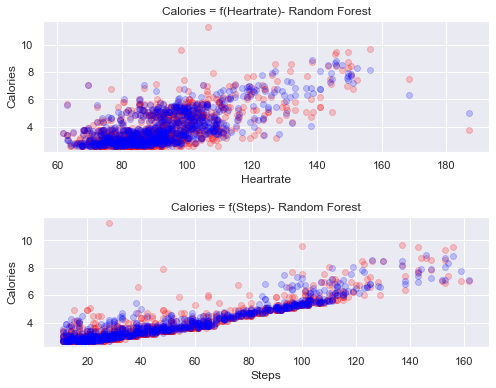

In [43]:
#Transforming our dataset for using it in our ML:

def multi_RandomForest(user_id):
    #Transforming our dataset for using it in our ML:
    #choosing 1 user:
    df = all_users.loc[(all_users.Id == user_id)]

    #deleting all non_dependent variables:
    df.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    #X = df.iloc[:,1:-1].values # Choosing Steps
    #X = df.iloc[:,2:].values # Choosing Heartbeat
    X = df.iloc[:,1:].values # Choosing Both
    y = df.iloc[:, 0].values.reshape(-1, 1)

    ###
    #Split data to train and test
    ###
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)


    ###
    #fit on train dataset
    ###
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(X_train, y_train)

    ###
    #Predict results
    ###
    y_pred = regressor.predict(X_test)

    ###
    #Evaluating the model
    ###
    rsq = r2_score(y_test, y_pred)
    
    return (rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor)


rsq, X_test,y_test,X_train,y_train,y_pred,X,regressor = multi_RandomForest(user_id)
    
Model_Descr.append('RandomForest')
Rsq.append(rsq)
print ('Rsquare =',"%.4f" % rsq)

###
#Visualising the Random Forest Regression results
###
###
#Visualising the SVR results
###
fig, (axs) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axs[0].scatter(X_test[:,1:], y_test, color = 'red',alpha = 0.2)
axs[0].scatter(X_test[:,1:], y_pred, color = 'blue',alpha = 0.2)

axs[0].set_title('Calories = f(Heartrate)- Random Forest')
axs[0].set_xlabel('Heartrate')
axs[0].set_ylabel('Calories')

axs[1].scatter(X_test[:,0:1], y_test, color = 'red',alpha = 0.2)
axs[1].scatter(X_test[:,0:1], y_pred, color = 'blue',alpha = 0.2)

axs[1].set_title('Calories = f(Steps)- Random Forest')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Calories')

plt.subplots_adjust(hspace=0.5,wspace=0.1)
plt.show()

In [44]:
#R_square values:
Rsquare_Values = [SLR_CalVsHeartrate(user_id)[0],SLR_CalVsSteps(user_id)[0], multi_linear(user_id)[0],
                  polyn_CalVsSteps(user_id)[0],polyn_CalVsHeart(user_id)[0],
                  multi_polyn_2nd(user_id)[0], multi_polyn_3rd(user_id)[0],
                  multi_SVR(user_id)[0], SVR_steps(user_id)[0],multi_RandomForest(user_id)[0]
                 ]

#Model descr:
Models = ['Linear_CalVsHeartrate','Linear_CalVsSteps','Multi_Linear',
          'Poly_CalVsSteps_2nd','Poly_CalVsHeart_2nd',
          'Poly_Multivariant_2nd','Poly_Multivariant_3rd',
          'multi_SVR', 'SVR_steps','RandomForest'       
         ]


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

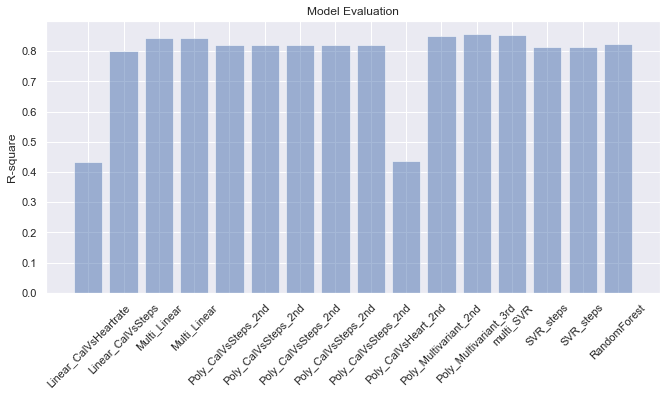

In [45]:
y_pos = np.arange(len(Model_Descr))
performance = Rsq

f = plt.figure()
f.set_figwidth(11)
f.set_figheight(5)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Model_Descr)
plt.ylabel('R-square')
plt.title('Model Evaluation')
plt.xticks(rotation= 45)

sns.set(style="whitegrid", color_codes=True)


plt.show()

In [46]:
###
#Top models:
###
sorted(zip(Rsq, Model_Descr), reverse=True)

[(0.8570709068320405, 'Poly_Multivariant_3rd'),
 (0.8531462858042915, 'multi_SVR'),
 (0.8499908292185265, 'Poly_Multivariant_2nd'),
 (0.8425357000346463, 'Multi_Linear'),
 (0.8425357000346463, 'Multi_Linear'),
 (0.8238014808749059, 'RandomForest'),
 (0.821439441006747, 'Poly_CalVsSteps_2nd'),
 (0.821439441006747, 'Poly_CalVsSteps_2nd'),
 (0.821439441006747, 'Poly_CalVsSteps_2nd'),
 (0.821439441006747, 'Poly_CalVsSteps_2nd'),
 (0.821439441006747, 'Poly_CalVsSteps_2nd'),
 (0.8142551152325368, 'SVR_steps'),
 (0.8142551152325368, 'SVR_steps'),
 (0.8007833334476463, 'Linear_CalVsSteps'),
 (0.43504125312156483, 'Poly_CalVsHeart_2nd'),
 (0.4346670590311126, 'Linear_CalVsHeartrate')]

### Conclusions:
- Top ML model for this user is Polynomial Regression, 3rd degree, with both Steps and Heartrate as independent variables. 
- Models that include both Steps and Heartrate as independent variables, perform better than those taking only one of the two as independent variable
- Models that consider only Steps to calculate Calories, outperform by a lot models that consider only the Heartrate.

Next, we built each model separately for each user, and evaluate the best model for each.

# Building regression models for each of the users:

In [47]:
#Making a df with only unique Ids
profiles_SLR_step = pd.DataFrame(by_min.Id.unique())
profiles_SLR_step.columns =['Id']

In [48]:
###
#Calculating the rsquare values for all models, for all users
###
Model_User_Rsquare_Values = []
for i in by_min.Id.unique():
    Rsquare_Values = [SLR_CalVsHeartrate(i)[0],SLR_CalVsSteps(i)[0], multi_linear(i)[0],
                  polyn_CalVsSteps(i)[0],polyn_CalVsHeart(i)[0],
                  multi_polyn_2nd(i)[0], multi_polyn_3rd(i)[0],
                  multi_SVR(i)[0], SVR_steps(i)[0],multi_RandomForest(i)[0]
                 ] #Calculates the Rsquare for every model, for each user
    
    Model_User_Rsquare_Values.append(Rsquare_Values) #makes a list of lists. 
                                                     #a list (for every user), of lists for all rsquared values per model

Models = ['Linear_CalVsHeartrate','Linear_CalVsSteps','Multi_Linear',
          'Poly_CalVsSteps_2nd','Poly_CalVsHeart_2nd',
          'Poly_Multivariant_2nd','Poly_Multivariant_3rd',
          'multi_SVR', 'SVR_steps','RandomForest'       
         ] #these are the model descriptions, in the same order as the lists of rsquared values for each user

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Savvas\AppData\Local\Temp/ipykernel_15544/2969697682.py:29: DataConversionWarning: A column-vector y was passed when a 1d a

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Savvas\AppData\Local\Temp/ipykernel_15544/2969697682.py:29: DataConversionWarning: A column-vector y was passed when a 1d a

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Savvas\AppData\Local\Temp/ipykernel_15544/2969697682.py:29: DataConversionWarning: A column-vector y was passed when a 1d a

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Savvas\AppData\Local\Temp/ipykernel_15544/2969697682.py:29: DataConversionWarning: A column-vector y was passed when a 1d a

# Choosing the best model for each user

In [49]:
BestModelperUser = pd.DataFrame()
BestModelperUser['Id'] = by_min.Id.unique()
BestModel = []
BestRsq = []
#choose the maximum of a list
for list in Model_User_Rsquare_Values:
    max_rsquared = max(list) #finding the max rsquared value for each user, through all the models 
    l = list.index(max_rsquared) # finding the index of the value
    best_model =  Models[l] # finding the description of the model
    BestModel.append(best_model) #tracking the progress by putting it in a list
    BestRsq.append(max_rsquared) #tracking the progress by putting it in a list

BestModelperUser['BestModel'] = BestModel
BestModelperUser['R2_total'] = BestRsq
BestModelperUser

,Id,BestModel,R2_total
0,2022484408,multi_SVR,0.857350
1,2026352035,RandomForest,0.791128
2,2347167796,Poly_Multivariant_3rd,0.857071
3,4020332650,Poly_Multivariant_3rd,0.761888
4,4388161847,Poly_Multivariant_3rd,0.824267
5,4558609924,multi_SVR,0.869494
6,5553957443,multi_SVR,0.952629
7,5577150313,Poly_Multivariant_3rd,0.617208
8,6117666160,multi_SVR,0.783149
9,6775888955,Poly_Multivariant_2nd,0.780165


# Conclusions:
- For the 14 different users (that we have available data), the best ML models for predicting the Calories are different. 
- How ever, all the best models, take into account both Steps and Heartrate as independent variables.
- The best models include:
    - Support Vector Regression,
    - Random Forest Regression,
    - Polynomial Regression (3rd degree)
    - Polynomial Regression (2nd degree)

In [50]:
###
#Total run time in min:
###
print('The total run time was:',(time.time()-t01)/60,' minutes')

The total run time was: 37.16801832914352  minutes
